# <h1><center> COMMUNICATION THROUGH DATA and STORY THROUGH VISUALIZATION </center></h1>

## <h1><center> “Time Series Analysis” to Forecast Crashes and Traffic Violations in Montgomery County, MD  </center></h1>


### Meenakshi Nerolu           
### Date: Dec 1, 2020

# Importing Libraries

In [63]:
## import packages:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # for vector operations
from numpy import percentile
import pandas as pd # for Data Frame methods
import pandas.util.testing as tm
import matplotlib.pyplot as plt # Two dimensional plotting library
import matplotlib as mpl
import seaborn as sns #  library for making statistical graphics
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools

#sklearn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import scikitplot as skplt

#Time-Series Analysis
import time
import datetime 
import dateutil
import statsmodels.api as sm
from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

# 1.Traffic Violation <a class="anchor" id="sec3"></a> 

## Reading "Traffic_Violations" data

In [ ]:
    # Reading csv file
    #traffic = pd.read_csv("Traffic_Violations.csv",low_memory=False)
    
    ## Downloading & Reading csv file from website
    url = 'https://data.montgomerycountymd.gov/api/views/4mse-ku6q/rows.csv?accessType=DOWNLOAD'
    traffic = pd.read_csv(url,low_memory=False)

In [ ]:
"""" UseFeatues() Function when called, returns a dataframe with additional features"""

def useFeatures(traffic):

    ## Formatting the Date
    ## Replace white space everywhere
    traffic.columns = traffic.columns.str.replace(' ', '')
    # Confirm the date column is in datetime format
    traffic['DateOfStop'] = pd.to_datetime(traffic['DateOfStop'])

    # Confirm the  time column is in datetime format
    traffic['TimeOfStop'] = pd.to_datetime(traffic['TimeOfStop'])
    # creating  new columns: date, year, month, day, time 
    traffic['date'] = pd.to_datetime(traffic['DateOfStop'])
    traffic['year'] = traffic['DateOfStop'].dt.year
    traffic['month'] = traffic['DateOfStop'].dt.month
    traffic['time'] = traffic['TimeOfStop'].dt.time
    traffic['hour'] = traffic['TimeOfStop'].dt.hour
    #traffic['day'] = traffic['DateOfStop'].dt.weekday_name
    traffic['day'] = traffic['DateOfStop'].dt.day_name()
    traffic = traffic.sort_values(by='date')
    

    
    ## Filtering the Desired Date Range - 2015 to 2020 ##
    traffic = traffic[traffic.date >='01/01/2015']
    traffic = traffic[traffic.date <'12/01/2020']
    traffic = traffic.reset_index(drop=True)
    
    traffic['season']= "Fall"
    traffic.loc[(traffic['month'] < 3) | (traffic['month'] >= 12), "season"] = 'Winter'
    traffic.loc[(traffic['month'] < 6) & (traffic['month'] >= 3), "season"] = 'Spring'
    traffic.loc[(traffic['month'] < 9) & (traffic['month'] >= 6), "season"] = 'Summer'
    
    ## Hour status
    ##traffic["hourStatus"] = "Evening"
    ## traffic.loc[( traffic["hour"] < 18) & ( traffic["wdayStatus"] == "Weekday"), "hourStatus"]="WorkHour"
    
    #Creating a new column to count the total number of violation
    traffic['Violation'] = pd.Series(1, index=traffic.index)
    
    return traffic

In [ ]:
# All the above features are stored in new data frame "traffic_features"
traffic_features = useFeatures(traffic)

In [ ]:
traffic_features.head()

## Replace Yes or No by 0 

In [ ]:
    ## Replace Yes and No by 1 and 0 respectively
traffic_replace = traffic_features.replace( {'Yes' : 1, 'No' : 0})
    
   
    ## replace the column name Year by Year_model
traffic_replace = traffic_replace.rename(columns={"Year":"Year_model"})
    
    # Delete the following columns as these columns have the highest number of NA's
delete_columns = traffic_replace[['SeqID', 'SearchConducted', 'SearchDisposition', 'SearchOutcome' , 'SearchReason', 'SearchReasonForStop', 'SearchType', 'SearchArrestReason']]
    
    # Delete these columns from the data frame, traffic_new
traffic_new = traffic_replace.drop(delete_columns ,axis=1)

In [ ]:
traffic_new["Color"].value_counts()

In [ ]:
#rename the colors :
traffic_new = traffic_new.replace({"BLUE, DARK":"BLUE" , "BLUE, LIGHT":"BLUE", "GREEN, DK":"GREEN", "GREEN, LGT":"GREEN" })
traffic_new.head()
print("Size of the data frame : ", traffic_new.shape)
#info() is used to check the Information about the data and the datatypes of each respective attribute.
print("Summary of columns ", traffic_new.info(verbose = False))
#This code prints a summary of columns count and its dtypes but not per column information.
print("\n\nThe column names in the dataframe \n\n :", traffic_new.columns)

In [ ]:
traffic_final = traffic_new.fillna(method='ffill')

In [ ]:
traffic_final.head()

In [ ]:
#obj_traffic_new = traffic_final.select_dtypes(include=['object']).copy()
#obj_traffic_new.head()
#traffic_new[obj_traffic_new]=traffic_new[obj_traffic_new].fillna("other")
#traffic_new = traffic_new.fillna("")
#traffic_new.head()

**Here onwards, I splitted entire data frame into two new data frames. One data is from 2015-2019 and another for the year 2020.** 

In [ ]:
is_2020 = traffic_final['year']==2020
is_2019 = traffic_final['year'] != 2020
#Creating Dataframe only for the year 2020
traffic_final_2020 = traffic_final[is_2020]
#Data from 2015- 2019
traffic_final_2019 = traffic_final[is_2019]
print("Size of the original data frame:", traffic_final.shape)
print("Size of the original data frame from 2015-2019:", traffic_final_2019.shape)
print("Size of the original data frame for the year 2020:", traffic_final_2020.shape)

In [ ]:
weekdays = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
violationweekday = traffic_final_2019.groupby(['year', 'day']).size()
#Reshape using unstack() function in Pandas python: 
violationweekday = violationweekday.rename_axis(['year', 'day'])\
                               .unstack('day')\
                               .reindex(columns=weekdays)
plt.figure(figsize=(15,10))
sns.heatmap(violationweekday, cmap='plasma_r')
plt.title('\n Violation by Weekday per Year (2015 - 2019)\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.savefig('images/violationsbyweekdayperyear.jpg')
plt.show()

In [ ]:
weekdays = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
violationweekday = traffic_final_2020.groupby(['month', 'day']).size()
#Reshape using unstack() function in Pandas python: 
violationweekday = violationweekday.rename_axis(['month', 'day'])\
                               .unstack('day')\
                               .reindex(columns=weekdays)
plt.figure(figsize=(15,10))
sns.heatmap(violationweekday, cmap='plasma_r')
plt.title('\n Violation by Weekday per month for the year 2020 \n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.savefig('images/violationsbyweekdayperyear.jpg')
plt.show()

In [ ]:
traffic_final.columns

In [ ]:
#def get_summary_statistics(dataset):


#    mean = np.round(np.mean(dataset), 2)
#    median = np.round(np.median(dataset), 2)
#    min_value = np.round(dataset.min(), 2)
#    max_value = np.round(dataset.max(), 2)
#    quartile_1 = np.round(dataset.quantile(0.25), 2)
#    quartile_3 = np.round(dataset.quantile(0.75), 2)
#    # Interquartile range
#    iqr = np.round(quartile_3 - quartile_1, 2)
#     print('Min: %s' % min_value)
#     print('Mean: %s' % mean)# # 
#     print('Max: %s' % max_va# # lue# )
#     print('25th percentile: # # %s'#  % quartile_1)
#     print('Median: %s' % med# ia# n)
#     print('75th percentile: %s# # ' % quartile_3)
#     print('Interquartile ran# # ge (IQR): %s' % iqr)
  # # #   
# # # # print('\n\n summary statistics from 2015-2020')
# # # get_summary_statistics(traffic_final)
# # print('\n\nVersicolor summary statistics from 2015-2019')
# get_summary_statistics(traffic_final_2019)
# p# rint('\n\nVersicolor summary statistics for the year 2020')
# get_summary_statistics(traffic_final_2020)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))  
sns.boxplot(x='year', y='hour', hue='Gender', data=traffic_final_2019, ax=ax)  
plt.show()  

# Machine Learning - Traffic Violation

In [ ]:
#CRNM_ML = CRNM_new.replace({'InjurySeverity' : {'SUSPECTED MINOR INJURY' : 'SUSPECTED_M_INJURY' , 'POSSIBLE INJURY': 'POSSIBLE_INJURY', 'SUSPECTED SERIOUS INJURY' : 'SUSPECTED_S_INJURY', 'NO APPARENT INJURY' : 'NO_APPARENT_INJURY','FATAL INJURY' : 'FATAL_INJURY' }})
traffic_ML_2019 = traffic_final_2019.copy()
traffic_ML_2020 = traffic_final_2020.copy()

# Binomial Classification : Can we predict drivers that are male with a Machine Learning model?

In [ ]:
# Create a DataFrame of female drivers
female_2020 = traffic_ML_2020[traffic_final_2020.Gender == 'F']

# Create a DataFrame of male drivers
male_2020 = traffic_ML_2020[traffic_final_2020.Gender == 'M']

# Create a DataFrame of female drivers
female_2019 = traffic_ML_2019[traffic_final_2019.Gender == 'F']

# Create a DataFrame of male drivers
male_2019 = traffic_ML_2019[traffic_final_2019.Gender == 'M']

# Compute the violation types by female drivers (as proportions)
print("Violation Type for females in the year 2020:\n", female_2020.ViolationType.value_counts())

print('-------------------------------')

# Compute the violation types by male drivers (as proportions)
print("Violation Type for males in the year 2020:\n", male_2020.ViolationType.value_counts())
print('-------------------------------')

# Compute the violations by female drivers (as proportions)
print("Violation Type for females from 2015-2019:\n", female_2019.ViolationType.value_counts())

print('-------------------------------')

# Compute the violations by male drivers (as proportions)
print("Violation Type for males from 2015-2019:\n", male_2019.ViolationType.value_counts())



In [ ]:
count_male_2019 = len(traffic_ML_2019[traffic_final_2019['Gender']=='M'])
count_female_2019 = len(traffic_ML_2019[traffic_final_2019['Gender']=='F'])
perc_of_male_2019 = count_male_2019/(count_male_2019+count_female_2019)
print("percentage of male from 2015-2019 :", perc_of_male_2019*100)
perc_of_female_2019 = count_female_2019/(count_male_2019+count_female_2019)
print("percentage of female from 2015-2019 :", perc_of_female_2019*100)
print("........................................................................")
count_male_2020 = len(traffic_final_2020[traffic_final_2020['Gender']=='M'])
count_female_2020 = len(traffic_final_2020[traffic_final_2020['Gender']=='F'])
perc_of_male_2020 = count_male_2020/(count_male_2020+count_female_2020)
print("percentage of male in the year 2020 :", perc_of_male_2020*100)
perc_of_female_2020 = count_female_2020/(count_male_2020+count_female_2020)
print("percentage of female in the year 2020 :", perc_of_female_2020*100)

We observe hear that classes are imbalanced. Ratio of male to female instances is 67:32 (from 2015-2019). It is interesting to note that percentage of male increased in the year 2020 and decreased for female.

In [ ]:
traffic_ML_2019_Gender=traffic_ML_2019[['ViolationType', 'Race', 'Color', 'VehicleType','Gender']]
traffic_ML_2019_Gender['Gender'] = np.where(traffic_ML_2019_Gender['Gender'].str.contains('M'), 1, 0)

traffic_ML_2020_Gender=traffic_ML_2020[['ViolationType', 'Race', 'Color', 'VehicleType','Gender']]
traffic_ML_2020_Gender['Gender'] = np.where(traffic_ML_2020_Gender['Gender'].str.contains('M'), 1, 0)

In [ ]:
traffic_ML_2019_Gender.head()

## Test and Train Data

For the performance of the model the data is split into the test data and train data. The data is split using the *train_test_split.* The data here is split in the ratio 80:20.

For the model prediction the logistic regression function is implemented by importing the logistic regression model in the sklearn module.

The model is then fit on the train set using the fit function. After this the prediction is performed using the prediction function.

In [ ]:
# Split the data into a training and test set.
features_gender_2019=pd.get_dummies(traffic_ML_2019_Gender.drop('Gender',axis=1))
target_gender_2019 =np.array(traffic_ML_2019_Gender['Gender'])
X_train_g2019, X_test_g2019, y_train_g2019, y_test_g2019 = train_test_split(features_gender_2019,target_gender_2019 
                                             ,test_size=0.20, random_state=99)

features_gender_2020=pd.get_dummies(traffic_ML_2020_Gender.drop('Gender' ,axis=1))
target_gender_2020 =np.array(traffic_ML_2020_Gender['Gender'])
X_train_g2020, X_test_g2020, y_train_g2020, y_test_g2020 = train_test_split(features_gender_2020,target_gender_2020 
                                             ,test_size=0.20, random_state=99)

In [ ]:
logmodel=LogisticRegression()
#logmodel=LogisticRegression(solver='liblinear', C=10.0)
## fit the model with data
logmodel.fit(X_train_g2019, y_train_g2019)
y_pred_g2019 = logmodel.predict(X_test_g2019)


print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_g2019, y_pred_g2019)*100))
print(".............................................................\n")
print("Accuracy score using logistic regression model:\n")
print("Score of our model is %2.2f%%" % (logmodel.score(X_train_g2019, y_train_g2019) * 100))

In [ ]:
print(classification_report(y_test_g2019,y_pred_g2019))

The classification report displays the **Precision, Recall , F1  and Support** scores for the model.

Precision score means the the level up-to which the prediction made by the model is precise. The precision for male is 0.67 and for female is 0.54.

Recall is the amount up-to which the model can predict the outcome. Recall for male is 1 and for female 0.01. 

In [ ]:
logmodel.fit(X_train_g2020, y_train_g2020)
y_pred_g2020 = logmodel.predict(X_test_g2020)


print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_g2020, y_pred_g2020)*100))
print(".............................................................\n")
print("Accuracy score using logistic regression model:\n")
print("Score of our model is %2.2f%%" % (logmodel.score(X_train_g2020, y_train_g2020) * 100))

In [ ]:
print(classification_report(y_test_g2020,y_pred_g2020))

### Confusion Matrix

Confusion matrix is a table which describes the performance of a prediction model. A confusion matrix contains the actual values and predicted values. we can use these values to calculate the accuracy score of the model.

In [ ]:
cnf_matrix_2019 = metrics.confusion_matrix(y_test_g2019,y_pred_g2019)
cnf_matrix_2019

### Confusion matrix heatmap

In [ ]:
#sns.heatmap(pd.DataFrame(confusion_matrix(y_test_g2019,y_pred_g2019)))
#plt.show()

In [ ]:
#from sklearn.metrics import roc_curve
#logit_roc_auc = roc_auc_score(y_test_g2019, logmodel.predict(X_test_g2019))
#fpr, tpr, thresholds = roc_curve(y_test_g2019, logmodel.predict_proba(X_test_g2019)[:,1])
#plt.figure()
#plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
#plt.show()

AUC score for the case is 0.50. AUC score 1 represents perfect classifier, and 0.5 is not good classifier. Thus, our model is not a very good classifier.

In [ ]:
rf = RandomForestClassifier()
lr = LogisticRegression()
nb = GaussianNB()
svm = LinearSVC()
rf_probas = rf.fit(X_train_g2019, y_train_g2019).predict_proba(X_test_g2019)
lr_probas = lr.fit(X_train_g2019, y_train_g2019).predict_proba(X_test_g2019)
nb_probas = nb.fit(X_train_g2019, y_train_g2019).predict_proba(X_test_g2019)
svm_scores = svm.fit(X_train_g2019, y_train_g2019).decision_function(X_test_g2019)
probas_list = [rf_probas, lr_probas, nb_probas, svm_scores]
clf_names = ['Random Forest', 'Logistic Regression',
             'Gaussian Naive Bayes', 'Support Vector Machine']
skplt.metrics.plot_calibration_curve(y_test_g2019,
                                      probas_list,
                                      clf_names)
plt.show()

### Cumulative Gain Curve
The cumulative gains chart also used to determine the effectiveness of a binary classifier.

In [ ]:
lr = LogisticRegression()
lr = lr.fit(X_train_g2019, y_train_g2019)
y_probas_g2019 = lr.predict_proba(X_test_g2019)
skplt.metrics.plot_cumulative_gain(y_test_g2019, y_probas_g2019)
plt.show()

In [ ]:
!pip install plot_metric

In [ ]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test_g2019, y_pred_g2019, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

###### When AUC is approximately 0.5, model has no discrimination capacity to distinguish between positive class and negative class. 

When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

# Multinomial Classification : Can we predict Violation Type?

In [ ]:
# Split the data into a training and test set.
features_vtype_2019=pd.get_dummies(traffic_ML_2019_Gender.drop('ViolationType' ,axis=1))
target_vtype_2019 = np.array((traffic_ML_2019_Gender['ViolationType']))

X_train_vt2019, X_test_vt2019, y_train_vt2019, y_test_vt2019 = train_test_split(features_vtype_2019,target_vtype_2019 
                                             ,test_size=0.20, random_state=99)

features_vtype_2020=pd.get_dummies(traffic_ML_2020_Gender.drop('ViolationType' ,axis=1))
target_vtype_2020 =np.array(traffic_ML_2020_Gender['ViolationType'])

X_train_vt2020, X_test_vt2020, y_train_vt2020, y_test_vt2020 = train_test_split(features_vtype_2020,target_vtype_2020 
                                             ,test_size=0.20, random_state=99)

In [ ]:
#fit model fort multi class
#mult_logmodel = OneVsRestClassifier(LogisticRegression())
mult_logmodel = LogisticRegression(solver='lbfgs',multi_class='multinomial')
mult_logmodel.fit(X_train_vt2019, y_train_vt2019)
y_pred_vt2019 = mult_logmodel.predict(X_test_vt2019)
y_pred_prob_vt2019 = mult_logmodel.predict_proba(X_test_vt2019)

print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_vt2019, y_pred_vt2019) * 100))

print("Accuracy score using multinominal logistic regression model:\n")
print("Score of our model is %2.2f%%" % (mult_logmodel.score(X_train_vt2019, y_train_vt2019) * 100))



In [ ]:
fpr = {}
tpr = {}
thresh = {}
n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_vt2019, y_pred_prob_vt2019[:,i], pos_label=i)
    
# plotting  
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [ ]:
cnf_matrix_2019_multiclass = metrics.confusion_matrix(y_test_vt2019,y_pred_vt2019)
cnf_matrix_2019_multiclass

### ROC Curve for multi-class

In [ ]:
#visualizer = ROCAUC(mult_logmodel, classes=["Warning", "Citation", "ESERO"])

#visualizer.fit(X_train_vt2019, y_train_vt2019)        # Fit the training data to the visualizer
#visualizer.score(X_test_vt2019, y_test_vt2019)        # Evaluate the model on the test data
#visualizer.show()                       # Finalize and render the figure
#roc_auc(multlogmodel, X_train_vt2019, y_train_vt2019, X_test_vt2019=X_test_vt2019, y_test_vt2019=y_test_vt2019, classes=["Warning", "Citation", "ESERO"])

In [ ]:
traffic_ML_2019_Gender['ViolationType'].value_counts()

In [ ]:
#print("ROC score",roc_auc_score(y_test, y_pred))
#print("F1 score",f1_score(y_test, y_pred))

# Multinomial Classification : Can we predict Vehicle Type?

In [ ]:
# Split the data into a training and test set.
from sklearn.multiclass import OneVsRestClassifier

features_vehicle_2019=pd.get_dummies(traffic_ML_2019_Gender.drop('VehicleType' ,axis=1))
target_vehicle_2019 = np.array((traffic_ML_2019_Gender['VehicleType']))

X_train_V2019, X_test_V2019, y_train_V2019, y_test_V2019 = train_test_split(features_vehicle_2019,target_vehicle_2019 
                                             ,test_size=0.20, random_state=99)

features_vehicle_2020=pd.get_dummies(traffic_ML_2020_Gender.drop('VehicleType' ,axis=1))
target_vehicle_2020 =np.array(traffic_ML_2020_Gender['VehicleType'])

X_train_V2020, X_test_V2020, y_train_V2020, y_test_V2020 = train_test_split(features_vehicle_2020,target_vehicle_2020 
                                             ,test_size=0.20, random_state=99)

In [ ]:
#fit model fort multi class
#mult_logmodel = OneVsRestClassifier(LogisticRegression())
mult_logmodel = LogisticRegression(solver='lbfgs',multi_class='multinomial')
mult_logmodel.fit(X_train_V2019, y_train_V2019)
y_pred_V2019 = mult_logmodel.predict(X_test_V2019)
y_pred_prob_V2019 = mult_logmodel.predict_proba(X_test_V2019)

print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_V2019, y_pred_V2019) * 100))

print("Accuracy score using logistic regression model:\n")
print("Score of our model is %2.2f%%" % (mult_logmodel.score(X_train_V2019, y_train_V2019) * 100))


**The score is the percentage of correct predictions in the test set. 90% is pretty good.**

In [ ]:
#y_pred_prob_V2019_a = mult_logmodel.predict_proba(X_test_V2019)[:,0]# for calculating the probability of the first class
#y_pred_prob_V2019_b = mult_logmodel.predict_proba(X_test_V2019)[:,1] # for calculating the probability of the second class

#fpr, tpr, thresholds = metrics.roc_curve(1-y_test_V2019,y_pred_prob_V2019_a)
#auc=metrics.auc(fpr, tpr)
#print("auc for the first class",auc)

#fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test_V2019,y_pred_brob_V2019_b)
#auc2=metrics.auc(fpr2, tpr2)
#print("auc for the second class",auc2)

# ploting the roc curve
#plt.plot(fpr,tpr)
#plt.plot(fpr2,tpr2)

#plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.title('Roc curve')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
#plt.legend(loc="lower right")
#plt.show()

# Crash Incident Data
https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf

https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Non-Motorists-Data/n7fk-dce5

# 2. Crash Reporting – Motorists Data 

In [2]:
    # Reading csv file
    #CRI= pd.read_csv("Crash_Reporting_-_Incidents_Data.csv")
    
    ## Downloading & Reading csv file from website
    url_CRI = 'https://data.montgomerycountymd.gov/api/views/bhju-22kf/rows.csv?accessType=DOWNLOAD'
    CRI = pd.read_csv(url_CRI,low_memory=False)

In [3]:
"""" UseFeatues() Function when called, returns a dataframe with additional features"""

def useFeatures(CRI):

    ## Formatting the Date
    
    # Confirm the date column is in datetime format
    CRI['Crash Date/Time'] = pd.to_datetime(CRI['Crash Date/Time'])
   
    # creating  new columns: date, year, month, day, time 
    CRI['date'] = pd.to_datetime(CRI['Crash Date/Time'])
    CRI['year'] = CRI['Crash Date/Time'].dt.year
    CRI['month'] = CRI['Crash Date/Time'].dt.month
    CRI['time'] = CRI['Crash Date/Time'].dt.time
    CRI['hour'] = CRI['Crash Date/Time'].dt.hour
    #CRI['day'] = CRI['Crash Date/Time'].dt.weekday_name
    CRI['day'] = CRI['Crash Date/Time'].dt.day_name()
    
    CRI = CRI.sort_values(by='date')
    

    
    ## Filtering the Desired Date Range - 2015 to 2020 ##
    CRI = CRI[CRI.date >='01/01/2015']
    CRI = CRI[CRI.date <'12/02/2020']
    CRI = CRI.reset_index(drop=True)
    
    CRI['season']= "Fall"
    CRI.loc[(CRI['month'] < 3) | (CRI['month'] >= 12), "season"] = 'Winter'
    CRI.loc[(CRI['month'] < 6) & (CRI['month'] >= 3), "season"] = 'Spring'
    CRI.loc[(CRI['month'] < 9) & (CRI['month'] >= 6), "season"] = 'Summer'
    
    ## Hour status
    ##traffic["hourStatus"] = "Evening"
    ## traffic.loc[( traffic["hour"] < 18) & ( traffic["wdayStatus"] == "Weekday"), "hourStatus"]="WorkHour"
    
    #Creating a new column to count the total number of violation
    CRI['crash'] = pd.Series(1, index=CRI.index)
    
    return CRI

In [4]:
# All the above features are stored in new data frame "CRI_features"
CRI_features = useFeatures(CRI)

In [5]:
## Replace white space everywhere
CRI_features.columns =CRI_features.columns.str.replace(' ', '')

In [6]:
 # Replace all NaN's by 0
#CRI_new = CRI_features.fillna(0)

#Renaming the column and replacing 
CRI_new =  CRI_features.rename(columns={"AgencyName": "Agency"})
CRI_new = CRI_new.replace({'Agency' : {'Montgomery County Police' : 'MCP', 'Rockville Police Departme' : 'RPD'}})
CRI_new.head()

,ReportNumber,LocalCaseNumber,Agency,ACRSReportType,CrashDate/Time,Hit/Run,RouteType,MilePoint,MilePointDirection,LaneDirection,...,Longitude,Location,date,year,month,time,hour,day,season,crash
0,MCP11520005,15000008,MCP,Property Damage Crash,2015-01-01 00:30:00,Yes,Maryland (State),4.38,North,North,...,-77.102673,"(39.02200107, -77.10267305)",2015-01-01 00:30:00,2015,1,00:30:00,0,Thursday,Winter,1
1,MCP2686000D,15000017,MCP,Property Damage Crash,2015-01-01 01:10:00,No,Ramp,0.15,South,South,...,-77.265547,"(39.19661, -77.26554667)",2015-01-01 01:10:00,2015,1,01:10:00,1,Thursday,Winter,1
2,MCP2783000G,15000025,MCP,Injury Crash,2015-01-01 01:14:00,No,Maryland (State),25.21,East,East,...,-77.109803,"(39.09621667, -77.10980333)",2015-01-01 01:14:00,2015,1,01:14:00,1,Thursday,Winter,1
3,MCP2674000D,15000016,MCP,Property Damage Crash,2015-01-01 01:26:00,No,County,0.76,North,West,...,-77.204349,"(39.158059, -77.204349)",2015-01-01 01:26:00,2015,1,01:26:00,1,Thursday,Winter,1
4,MCP23000002,15000197,MCP,Property Damage Crash,2015-01-01 02:00:00,No,County,1.81,North,North,...,-77.093848,"(39.148678, -77.093848)",2015-01-01 02:00:00,2015,1,02:00:00,2,Thursday,Winter,1


In [7]:
CRI_new['Rush_time']=CRI_new['CrashDate/Time'].dt.hour
#create Rush Time by grouping

def rushhour_CRI(hour):
    if hour >= 6 and hour < 10:
        return "Morning Rush"
    elif hour >= 10 and hour < 12:
        return "Day"
    elif hour >= 12 and hour < 14:
        return "Lunch Rush"
    elif hour >= 14 and hour < 16:
        return "Afternoon"
    elif hour >= 16 and hour < 18:
        return "Evening Rush"
    elif hour >= 18 and hour < 22:
        return "Evening"
    else:
        return "Night"

In [8]:
#apply function   
CRI_new['Rush_time']= CRI_new['Rush_time'].apply(rushhour_CRI)

In [9]:
CRI_final = CRI_new.fillna(method='ffill')

**Here onwards, I splitted entire data frame into two new data frames. One data is from 2015-2019 and another for the year 2020.** 

In [10]:
CRI_is_2020 =CRI_final['year']==2020
CRI_is_2019 = CRI_final['year'] != 2020
#Creating Dataframe only for the year 2020
CRI_final_2020 = CRI_final[CRI_is_2020]
#Data from 2015- 2019
CRI_final_2019 = CRI_final[CRI_is_2019]
print("Size of the original data frame:",CRI_final.shape)
print("Size of the original data frame from 2015-2019:", CRI_final_2019.shape)
print("Size of the original data frame for the year 2020:", CRI_final_2020.shape)

Size of the original data frame: (66480, 53)
Size of the original data frame from 2015-2019: (59200, 53)
Size of the original data frame for the year 2020: (7280, 53)


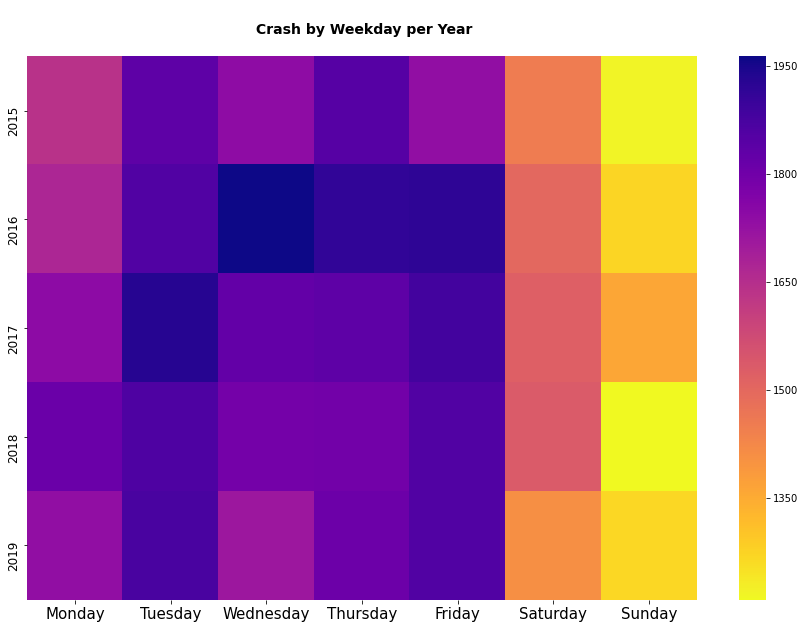

In [11]:
CRIweekday = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
CRI_weekday = CRI_final_2019.groupby(['year', 'day']).size()
#Reshape using unstack() function in Pandas python: 
CRI_weekday = CRI_weekday.rename_axis(['year', 'day'])\
                               .unstack('day')\
                               .reindex(columns=CRIweekday)
plt.figure(figsize=(15,10))
sns.heatmap(CRI_weekday, cmap='plasma_r')
plt.title('\n Crash by Weekday per Year\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
#plt.savefig('crashbyweekdayperyear.jpg')
plt.show()
#plt.savefig('images/CRIbyweekdayperyear.jpg')

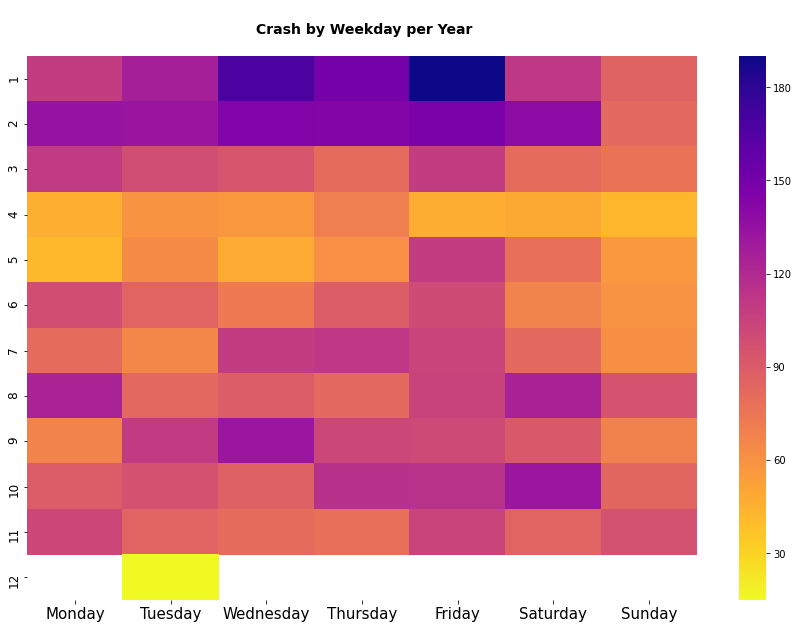

In [12]:
CRIweekday = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
CRI_weekday = CRI_final_2020.groupby(['month', 'day']).size()
#Reshape using unstack() function in Pandas python: 
CRI_weekday = CRI_weekday.rename_axis(['month', 'day'])\
                               .unstack('day')\
                               .reindex(columns=CRIweekday)
plt.figure(figsize=(15,10))
sns.heatmap(CRI_weekday, cmap='plasma_r')
plt.title('\n Crash by Weekday per Year\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
#plt.savefig('crashbyweekdayperyear.jpg')
plt.show()
#plt.savefig('images/CRIbyweekdayperyear.jpg')

# 2b. Crash Reporting – Non - Motorists Data

In [13]:
    # Reading csv file
    #CRI= pd.read_csv("Crash_Reporting_-_Incidents_Data.csv")
    
    ## Downloading & Reading csv file from website
    url_CRNM = 'https://data.montgomerycountymd.gov/api/views/n7fk-dce5/rows.csv?accessType=DOWNLOAD'
    CRNM= pd.read_csv(url_CRNM,low_memory=False)

In [14]:
"""" UseFeatues() Function when called, returns a dataframe with additional features"""

def useFeatures(CRNM):

    ## Formatting the Date
    
    # Confirm the date column is in datetime format
    CRNM['Crash Date/Time'] = pd.to_datetime(CRNM['Crash Date/Time'])
   
    # creating  new columns: date, year, month, day, time 
    CRNM['date'] = pd.to_datetime(CRNM['Crash Date/Time'])
    CRNM['year'] = CRNM['Crash Date/Time'].dt.year
    CRNM['month'] = CRNM['Crash Date/Time'].dt.month
    CRNM['time'] = CRNM['Crash Date/Time'].dt.time
    CRNM['hour'] = CRNM['Crash Date/Time'].dt.hour
    #CRNM['day'] = CRNM['Crash Date/Time'].dt.weekday_name
    CRNM['day'] = CRNM['Crash Date/Time'].dt.day_name()
    
    CRNM = CRNM.sort_values(by='date')
    

    
    ## Filtering the Desired Date Range - 2015 to 2020 ##
    CRNM = CRNM[CRNM.date >='01/01/2015']
    CRNM = CRNM[CRNM.date <'12/02/2020']
    CRNM = CRNM.reset_index(drop=True)
    
    CRNM['season']= "Fall"
    CRNM.loc[(CRNM['month'] < 3) | (CRNM['month'] >= 12), "season"] = 'Winter'
    CRNM.loc[(CRNM['month'] < 6) & (CRNM['month'] >= 3), "season"] = 'Spring'
    CRNM.loc[(CRNM['month'] < 9) & (CRNM['month'] >= 6), "season"] = 'Summer'
    
    ## Hour status
    ##traffic["hourStatus"] = "Evening"
    ## traffic.loc[( traffic["hour"] < 18) & ( traffic["wdayStatus"] == "Weekday"), "hourStatus"]="WorkHour"
    
    #Creating a new column to count the total number of violation
    CRNM['crash'] = pd.Series(1, index=CRNM.index)
    
    return CRNM

In [15]:
# All the above features are stored in new data frame "CRI_features"
CRNM_features = useFeatures(CRNM)

In [16]:
## Replace white space everywhere
CRNM_features.columns =CRNM_features.columns.str.replace(' ', '')

In [17]:
 # Replace all NaN's by 0
#CRNM_new = CRNM_features.fillna(0)

#Renaming the column and replacing 
CRNM_new =  CRNM_features.rename(columns={"AgencyName": "Agency"})
CRNM_new = CRNM_new.replace({'Agency' : {'Montgomery County Police' : 'MCP', 'Rockville Police Departme' : 'RPD'}})
CRNM_new.head()

,ReportNumber,LocalCaseNumber,Agency,ACRSReportType,CrashDate/Time,RouteType,RoadName,Cross-StreetType,Cross-StreetName,Off-RoadDescription,...,Longitude,Location,date,year,month,time,hour,day,season,crash
0,MCP2439000D,14064779,MCP,Injury Crash,2015-01-01 18:00:00,County,CONTOUR RD,County,HORIZON RUN RD,NaN,...,-77.197752,"(39.1552397, -77.197752)",2015-01-01 18:00:00,2015,1,18:00:00,18,Thursday,Winter,1
1,DD5508000L,15000253,RPD,Injury Crash,2015-01-02 11:51:00,NaN,NaN,NaN,NaN,Parking Lot of 14939 Shady Grove Rd,...,-77.192452,"(39.09749501, -77.19245195)",2015-01-02 11:51:00,2015,1,11:51:00,11,Friday,Winter,1
2,MCP2690000N,15000473,MCP,Injury Crash,2015-01-03 20:31:00,NaN,NaN,NaN,NaN,Parking Lot 13 at 11219 Grandview Ave,...,-77.051365,"(39.03882591, -77.05136508)",2015-01-03 20:31:00,2015,1,20:31:00,20,Saturday,Winter,1
3,MCP27650015,15000583,MCP,Injury Crash,2015-01-04 14:55:00,NaN,NaN,NaN,NaN,Parking lot of Giant Food (12051 Rockville Pike),...,-77.087983,"(38.96282667, -77.08798333)",2015-01-04 14:55:00,2015,1,14:55:00,14,Sunday,Winter,1
4,MCP9379000G,15000697,MCP,Injury Crash,2015-01-05 12:23:00,Maryland (State),FREDERICK RD,Municipality,KING FARM BLVD,NaN,...,-77.168492,"(39.116905, -77.16849167)",2015-01-05 12:23:00,2015,1,12:23:00,12,Monday,Winter,1


In [18]:
CRNM_new['Rush_time']=CRNM_new['CrashDate/Time'].dt.hour
#create Rush Time by grouping

def rushhour_CRNM(hour):
    if hour >= 6 and hour < 10:
        return "Morning Rush"
    elif hour >= 10 and hour < 12:
        return "Day"
    elif hour >= 12 and hour < 14:
        return "Lunch Rush"
    elif hour >= 14 and hour < 16:
        return "Afternoon"
    elif hour >= 16 and hour < 18:
        return "Evening Rush"
    elif hour >= 18 and hour < 22:
        return "Evening"
    else:
        return "Night"


In [19]:
#apply function   
CRNM_new['Rush_time']= CRNM_new['Rush_time'].apply(rushhour_CRNM)
#CRNM_new.head()

In [20]:
CRNM_final = CRNM_new.fillna(method='ffill')
CRNM_final.head()

,ReportNumber,LocalCaseNumber,Agency,ACRSReportType,CrashDate/Time,RouteType,RoadName,Cross-StreetType,Cross-StreetName,Off-RoadDescription,...,Location,date,year,month,time,hour,day,season,crash,Rush_time
0,MCP2439000D,14064779,MCP,Injury Crash,2015-01-01 18:00:00,County,CONTOUR RD,County,HORIZON RUN RD,NaN,...,"(39.1552397, -77.197752)",2015-01-01 18:00:00,2015,1,18:00:00,18,Thursday,Winter,1,Evening
1,DD5508000L,15000253,RPD,Injury Crash,2015-01-02 11:51:00,County,CONTOUR RD,County,HORIZON RUN RD,Parking Lot of 14939 Shady Grove Rd,...,"(39.09749501, -77.19245195)",2015-01-02 11:51:00,2015,1,11:51:00,11,Friday,Winter,1,Day
2,MCP2690000N,15000473,MCP,Injury Crash,2015-01-03 20:31:00,County,CONTOUR RD,County,HORIZON RUN RD,Parking Lot 13 at 11219 Grandview Ave,...,"(39.03882591, -77.05136508)",2015-01-03 20:31:00,2015,1,20:31:00,20,Saturday,Winter,1,Evening
3,MCP27650015,15000583,MCP,Injury Crash,2015-01-04 14:55:00,County,CONTOUR RD,County,HORIZON RUN RD,Parking lot of Giant Food (12051 Rockville Pike),...,"(38.96282667, -77.08798333)",2015-01-04 14:55:00,2015,1,14:55:00,14,Sunday,Winter,1,Afternoon
4,MCP9379000G,15000697,MCP,Injury Crash,2015-01-05 12:23:00,Maryland (State),FREDERICK RD,Municipality,KING FARM BLVD,Parking lot of Giant Food (12051 Rockville Pike),...,"(39.116905, -77.16849167)",2015-01-05 12:23:00,2015,1,12:23:00,12,Monday,Winter,1,Lunch Rush


**Here onwards, I splitted entire data frame into two new data frames. One data is from 2015-2019 and another for the year 2020.** 

In [21]:
CRNM_is_2020 =CRNM_final['year']==2020
CRNM_is_2019 = CRNM_final['year'] != 2020
#Creating Dataframe only for the year 2020
CRNM_final_2020 = CRNM_final[CRNM_is_2020]
#Data from 2015- 2019
CRNM_final_2019 = CRNM_final[CRNM_is_2019]
print("Size of the original data frame:",CRNM_final.shape)
print("Size of the original data frame from 2015-2019:", CRNM_final_2019.shape)
print("Size of the original data frame for the year 2020:", CRNM_final_2020.shape)

Size of the original data frame: (3839, 41)
Size of the original data frame from 2015-2019: (3347, 41)
Size of the original data frame for the year 2020: (492, 41)


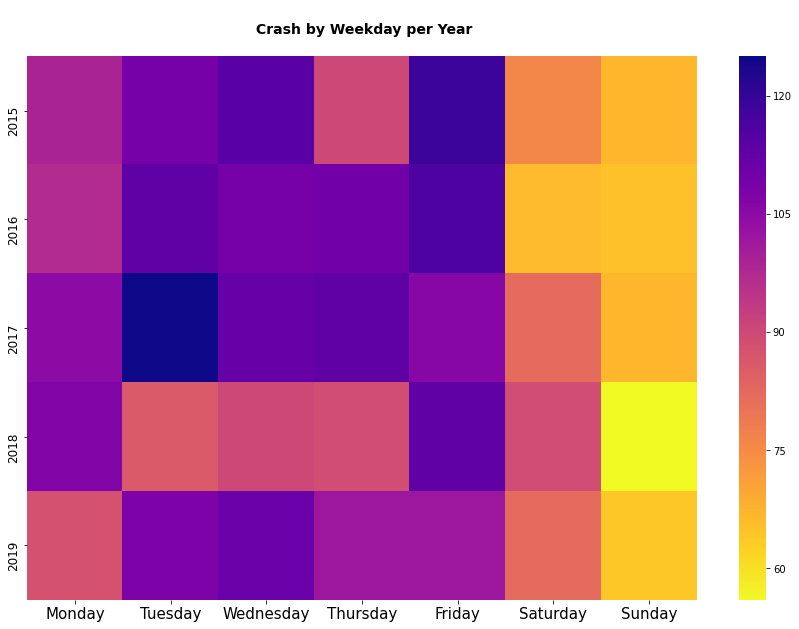

In [22]:
CRNMweekday = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
CRNM_weekday = CRNM_final_2019.groupby(['year', 'day']).size()
#Reshape using unstack() function in Pandas python: 
CRNM_weekday = CRNM_weekday.rename_axis(['year', 'day'])\
                               .unstack('day')\
                               .reindex(columns=CRIweekday)
plt.figure(figsize=(15,10))
sns.heatmap(CRNM_weekday, cmap='plasma_r')
plt.title('\n Crash by Weekday per Year\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
#plt.savefig('crashbyweekdayperyear.jpg')
plt.show()
#plt.savefig('images/CRDbyweekdayperyear.jpg')

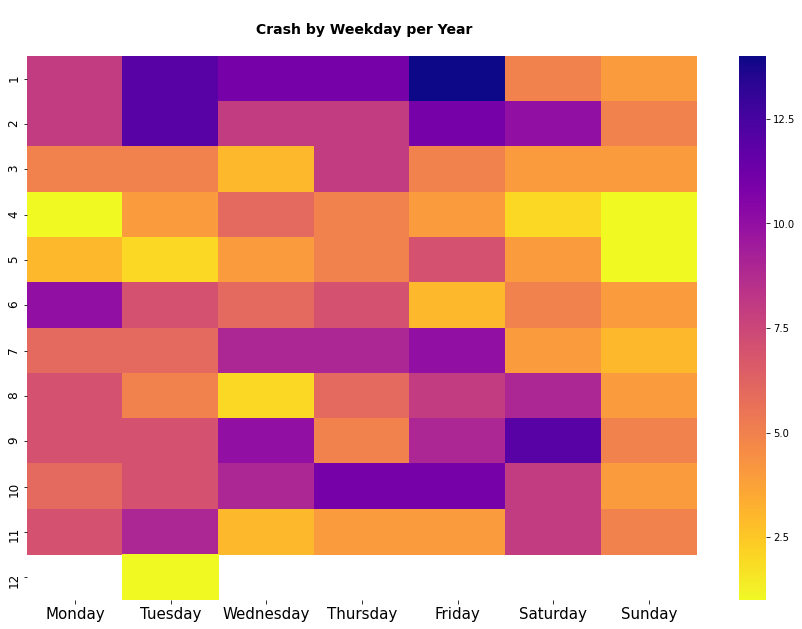

In [23]:
CRNMweekday = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
CRNM_weekday = CRNM_final_2020.groupby(['month', 'day']).size()
#Reshape using unstack() function in Pandas python: 
CRNM_weekday = CRNM_weekday.rename_axis(['month', 'day'])\
                               .unstack('day')\
                               .reindex(columns=CRIweekday)
plt.figure(figsize=(15,10))
sns.heatmap(CRNM_weekday, cmap='plasma_r')
plt.title('\n Crash by Weekday per Year\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
#plt.savefig('crashbyweekdayperyear.jpg')
plt.show()
#plt.savefig('images/CRDbyweekdayperyear.jpg')

# Time Series (Motorists Data)

## Predicting Future Crash related to Mototrists using *Facebook Prophet*

In [31]:
#2015-2020
#Creating a new dataframe for time series analysis with date as an index
CRI_timeseries_2019 = CRI_final_2019.copy()
CRI_timeseries_2019.rename(columns = {'CrashDate/Time':'CrashDate_Time'}, inplace = True) 
CRI_timeseries_2019['date'] = pd.to_datetime(CRI_timeseries_2019['date'])
CRI_timeseries_2019 = CRI_timeseries_2019.set_index('date')


#Time series data for the year 2020
CRI_timeseries_2020 = CRI_final_2020.copy()
CRI_timeseries_2020.rename(columns = {'CrashDate/Time':'CrashDate_Time'}, inplace = True) 
CRI_timeseries_2020['date'] = pd.to_datetime(CRI_timeseries_2020['date'])
CRI_timeseries_2020 = CRI_timeseries_2020.set_index('date')
CRI_timeseries_2020.head()

,ReportNumber,LocalCaseNumber,Agency,ACRSReportType,CrashDate_Time,Hit/Run,RouteType,MilePoint,MilePointDirection,LaneDirection,...,Longitude,Location,year,month,time,hour,day,season,crash,Rush_time
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:18:00,MCP27200046,200000011,MCP,Injury Crash,2020-01-01 01:18:00,No,Maryland (State),0.210,North,North,...,-77.050186,"(39.06317431, -77.05018556)",2020,1,01:18:00,1,Wednesday,Winter,1,Night
2020-01-01 02:35:00,MCP3097001J,20000002,MCP,Property Damage Crash,2020-01-01 02:35:00,Yes,Maryland (State),0.210,North,North,...,-76.981307,"(39.04137761, -76.98130678)",2020,1,02:35:00,2,Wednesday,Winter,1,Night
2020-01-01 08:17:00,MCP3021004Z,200000041,MCP,Injury Crash,2020-01-01 08:17:00,No,US (State),5.655,North,North,...,-76.978948,"(39.05139106, -76.97894797)",2020,1,08:17:00,8,Wednesday,Winter,1,Morning Rush
2020-01-01 09:57:00,MCP9428002M,200000044,MCP,Injury Crash,2020-01-01 09:57:00,No,County,1.760,East,West,...,-77.258633,"(39.23213833, -77.25863333)",2020,1,09:57:00,9,Wednesday,Winter,1,Morning Rush
2020-01-01 11:49:00,MCP3211000Q,200000057,MCP,Property Damage Crash,2020-01-01 11:49:00,Yes,County,0.120,East,North,...,-77.120058,"(38.96457911, -77.120058)",2020,1,11:49:00,11,Wednesday,Winter,1,Day


In [43]:
plt.rcdefaults()
CRI_per_day_2020=CRI_timeseries_2020['crash'].groupby(CRI_timeseries_2020.index.date).sum()
CRI_per_day_2019=CRI_timeseries_2019['crash'].groupby(CRI_timeseries_2019.index.date).sum()

CRI_timeseries_prophet_2019 = pd.DataFrame(CRI_per_day_2019)
CRI_timeseries_prophet_2019 = CRI_timeseries_prophet_2019.rename(columns={'crash' : 'y'})
CRI_timeseries_prophet_2019['ds'] = CRI_timeseries_prophet_2019.index

CRI_timeseries_prophet_2020 = pd.DataFrame(CRI_per_day_2020)
CRI_timeseries_prophet_2020 = CRI_timeseries_prophet_2020.rename(columns={'crash' : 'y'})
CRI_timeseries_prophet_2020['ds'] = CRI_timeseries_prophet_2020.index

print("Time series data frame 2015-2019:\n",CRI_timeseries_prophet_2019 .head())
print("\n____________________________________________________________________________\n")
print("Time series data frame 2020:\n",CRI_timeseries_prophet_2020 .head())

Time series data frame 2015-2019:
              y          ds
2015-01-01  26  2015-01-01
2015-01-02  22  2015-01-02
2015-01-03  37  2015-01-03
2015-01-04  25  2015-01-04
2015-01-05  25  2015-01-05

____________________________________________________________________________

Time series data frame 2020:
              y          ds
2020-01-01  15  2020-01-01
2020-01-02  32  2020-01-02
2020-01-03  51  2020-01-03
2020-01-04  34  2020-01-04
2020-01-05  22  2020-01-05


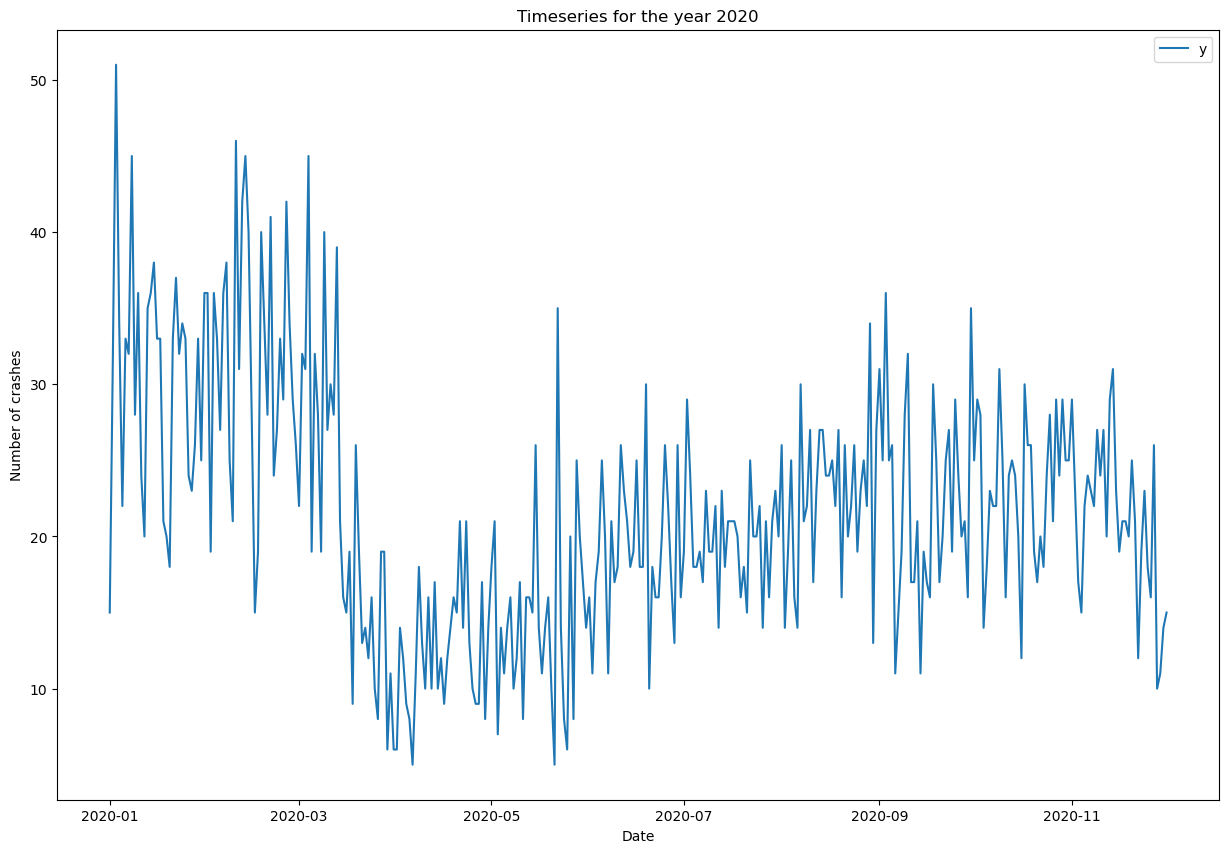

In [47]:
ax = CRI_timeseries_prophet_2020.set_index('ds').plot(figsize=(15, 10))
ax.set_ylabel('Number of crashes')
ax.set_xlabel('Date')
#plt.xticks(rotation=45)
plt.title("Timeseries for the year 2020")
#plt.show()
plt.show()

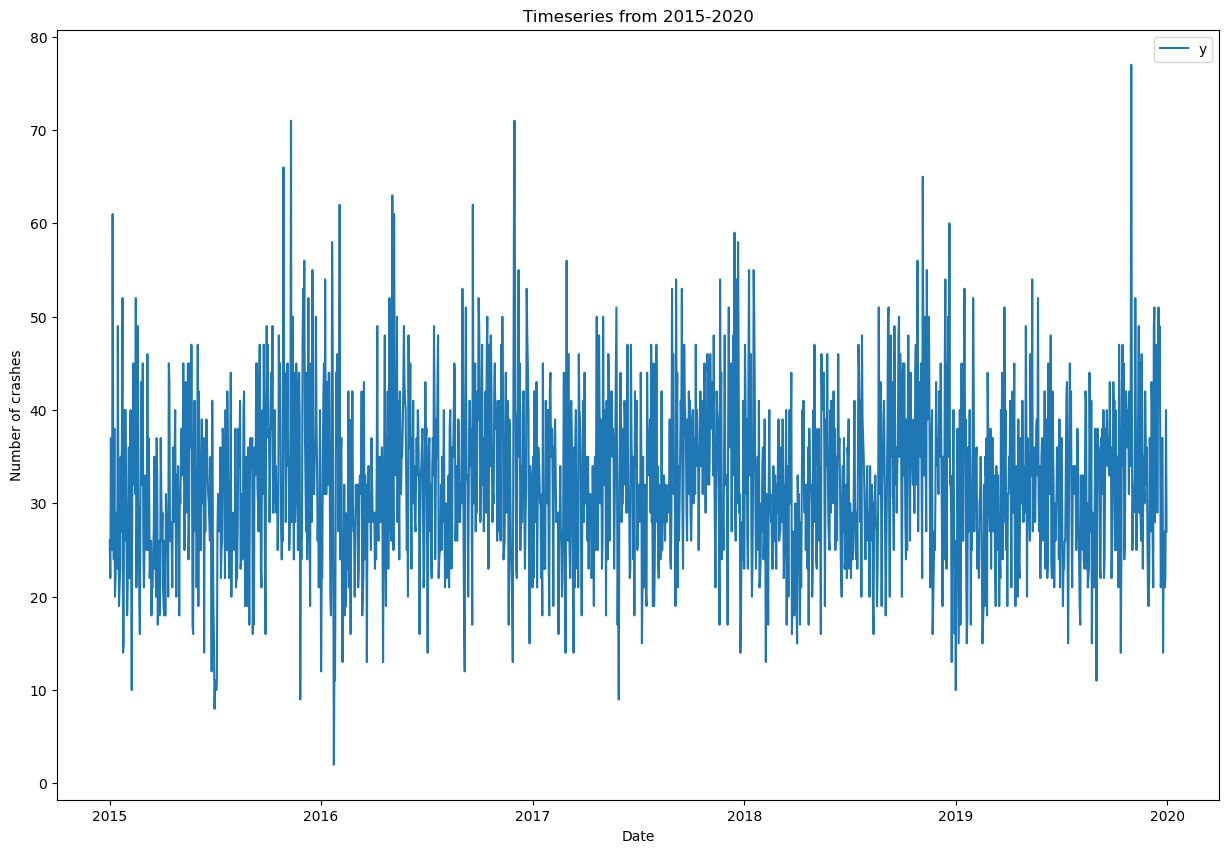

In [46]:
ax = CRI_timeseries_prophet_2019.set_index('ds').plot(figsize=(15, 10))
ax.set_ylabel('Number of crashes')
ax.set_xlabel('Date')
plt.title("Timeseries from 2015-2020")
plt.show()

## Fitting the Prophet Model - Motorists Data

In [67]:
#Set the uncertainty interval to 95% (the Prophet default is 80%)
#from fbprophet import Prophet

CRI_prohet_model_2019 = Prophet(interval_width=0.95,daily_seasonality=True)
CRI_prohet_model_2019.fit(CRI_timeseries_prophet_2019)

CRI_prohet_model_2020 = Prophet(interval_width=0.95,daily_seasonality=True)
CRI_prohet_model_2020.fit(CRI_timeseries_prophet_2020)

future_dates_CRI_2019 = CRI_prohet_model_2019.make_future_dataframe(periods=30, freq='MS') 

future_dates_CRI_2020 = CRI_prohet_model_2020.make_future_dataframe(periods=12, freq='MS') 
#print(future_dates_violation.tail())
#print(future_dates_violation_2019.tail())
#print(future_dates_violation_2020.tail())

forecast_CRI_2019 = CRI_prohet_model_2019.predict(future_dates_CRI_2019)

forecast_CRI_2020 = CRI_prohet_model_2020.predict(future_dates_CRI_2020)

#print(forecast_violation[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
#print(forecast_violation_2019[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
#print(forecast_violation_2020[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [68]:
plot_plotly(CRI_prohet_model_2020, forecast_CRI_2020)

In [69]:
plot_plotly(CRI_prohet_model_2019, forecast_CRI_2019)
#plt.title("Timeseries from 2015-2020")

In [70]:
plot_components_plotly(CRI_prohet_model_2020, forecast_CRI_2020)

In [71]:
plot_components_plotly(CRI_prohet_model_2019, forecast_CRI_2019)

# Points of Changes
In the following visualization, change-points have been added (where the trend model is shifting):

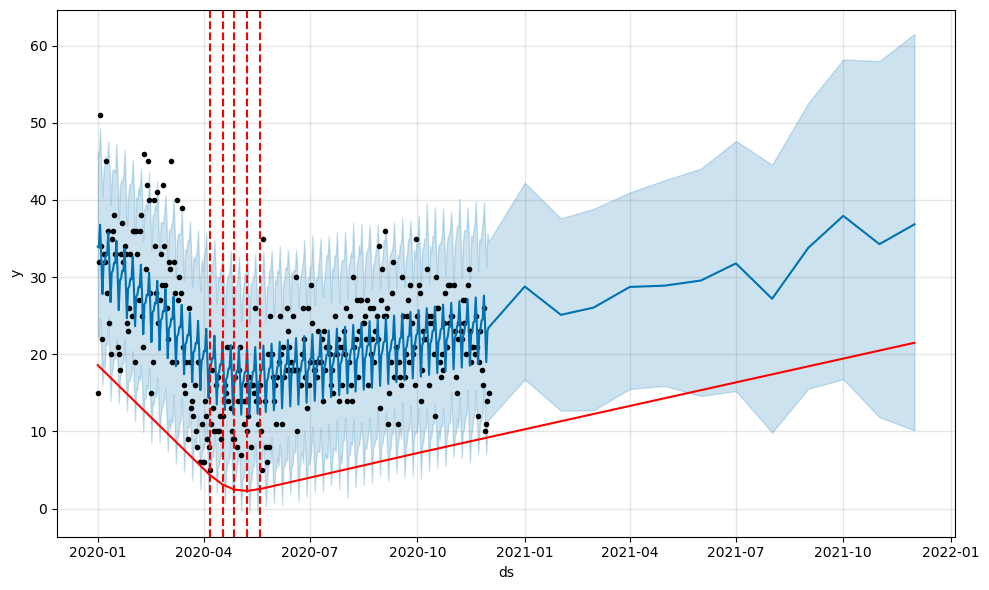

In [72]:
fig_2020=CRI_prohet_model_2020.plot(forecast_CRI_2020)
changes_2020=add_changepoints_to_plot(fig_2020.gca(),CRI_prohet_model_2020,forecast_CRI_2020)

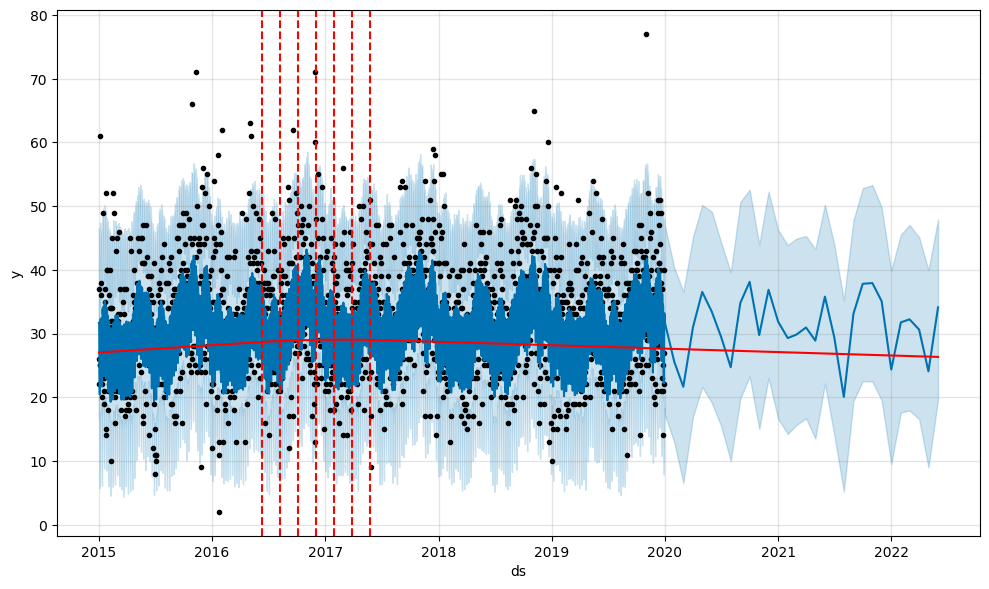

In [73]:
fig_2019=CRI_prohet_model_2019.plot(forecast_CRI_2019)
changes_2019=add_changepoints_to_plot(fig_2019.gca(),CRI_prohet_model_2019,forecast_CRI_2019)

In [76]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=CRI_timeseries_prophet_2019['ds'], y=CRI_timeseries_prophet_2019['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast_CRI_2019['ds'], y=forecast_CRI_2019['yhat'], name='Predicted',))
#fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.update_layout(
    title="Actual (2015-2019) Vs Predicted (for 2 and half year)",
    xaxis_title="Date",
    yaxis_title="Number of Crashes",
       font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

In [77]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=CRI_timeseries_prophet_2020['ds'], y=CRI_timeseries_prophet_2020['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast_CRI_2020['ds'], y=forecast_CRI_2020['yhat'], name='Predicted',))
#fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.update_layout(
    title="Actual (2020) Vs Predicted (for 1 year)",
    xaxis_title="Date",
    yaxis_title="Number of Crashes",
       font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

In [ ]:
fig= go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=CRI_timeseries_prophet_2020['ds'], y=CRI_timeseries_prophet_2020['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast_CRI_2020['ds'], y=forecast_CRI_2020['yhat'], name='Predicted',))
#fig.add_trace(go.Scatter(x=forecast_violation_2020['ds'], y=forecast_violation_2020['holidays'], name='Holidays',))
#fig.title("Actual Vs Predicted")
fig.update_layout(
    title="Actual Vs Predicted",
    xaxis_title="Date",
    yaxis_title="Number of Violations",
       font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

In [87]:
metric_forecast_CRI_2020 = forecast_CRI_2020.set_index('ds')[['yhat']].join(CRI_timeseries_prophet_2020.set_index('ds').y).reset_index()
metric_forecast_CRI_2020.dropna(inplace=True)

metric_forecast_CRI_2019 = forecast_CRI_2019.set_index('ds')[['yhat']].join(CRI_timeseries_prophet_2019.set_index('ds').y).reset_index()
metric_forecast_CRI_2019.dropna(inplace=True)
metric_forecast_CRI_2020.tail()

,ds,yhat,y
331,2020-11-27,27.605484,26.0
332,2020-11-28,23.730094,10.0
333,2020-11-29,18.979819,11.0
334,2020-11-30,22.999216,14.0
335,2020-12-01,23.454858,15.0


In [88]:
print("r2 value for the year 2020",r2_score(metric_forecast_CRI_2020.y, metric_forecast_CRI_2020.yhat))
print("r2 value from 2015-2020",r2_score(metric_forecast_CRI_2019.y, metric_forecast_CRI_2019.yhat))

r2 value for the year 2020 0.4241985569047829
r2 value from 2015-2020 0.31326441486311474


In [ ]:
#clf = RandomForestClassifier(n_estimators=50, random_state=23)
#model = clf.fit(X_train_g2019, y_train_g2019)

# Use predict_proba to predict probability of the class
#y_pred = clf.predict_proba(X_test_g2019)[:,1]


In [ ]:
#bc = BinaryClassification(y_test_g2019, y_pred_g2019, labels=["Class 0", "Class 1"])

# Figures
#plt.figure(figsize=(15,10))
#plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#bc.plot_roc_curve()
#plt.subplot2grid((2,6), (0,2), colspan=2)
#bc.plot_precision_recall_curve()
#plt.subplot2grid((2,6), (0,4), colspan=2)
#bc.plot_class_distribution()
#plt.subplot2grid((2,6), (1,1), colspan=2)
#bc.plot_confusion_matrix()
#plt.subplot2grid((2,6), (1,3), colspan=2)
#bc.plot_confusion_matrix(normalize=True)
#plt.show()
#bc.print_report()